In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Food101 paper
- Link of the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

**This notebook is inspired from ZTM's Tensorflow course**<br>
Link: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb


## Importing helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-11 08:50:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-11 08:50:05 (39.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Downloading and preprocessing data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2023-06-11 08:50:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   241MB/s    in 6.3s    

2023-06-11 08:50:21 (245 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
len(train_dir), len(test_dir)

(34, 33)

In [8]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 image

In [9]:
import tensorflow as tf
from tensorflow.keras import preprocessing

In [10]:
train_data_gen = preprocessing.image_dataset_from_directory(train_dir,
                                                            label_mode="categorical",
                                                            image_size=(224, 224),
                                                            batch_size=32)

test_data_gen = preprocessing.image_dataset_from_directory(test_dir,
                                                           label_mode="categorical",
                                                           image_size=(224, 224),
                                                           batch_size=32,
                                                           shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Creating `ModelCheckpoint`

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
checkpoint_path = "10_percent_data_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

## Creating the augmentation layer

In [13]:
from tensorflow.keras import layers, Sequential

In [14]:
data_augmentation = Sequential([
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal")
], name="data_augmentation")

## Importing `EfficientNetV2B0` as `base_model`

In [15]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

24274472/24274472 [==============================] - 0s 0us/step


## Creating first model `model_0`

In [16]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(train_data_gen.class_names), activation="softmax", name="output_layer")(x)

In [17]:
# don't know how many model we are going to create so, named model_0
model_0 = tf.keras.Model(inputs, outputs)

In [18]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [19]:
history_0 = model_0.fit(train_data_gen,
            epochs=5,
            steps_per_epoch=len(train_data_gen),
            validation_data=test_data_gen,
            validation_steps=int(0.15 * len(test_data_gen)),
            callbacks=[create_tensorboard_callback("transfer_learning", "model_0"),
                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_0/20230611-085045
Epoch 1/5
237/237 [==============================] - 99s 356ms/step - loss: 3.5187 - accuracy: 0.2403 - val_loss: 2.6953 - val_accuracy: 0.4256
Epoch 2/5
237/237 [==============================] - 61s 256ms/step - loss: 2.4076 - accuracy: 0.4632 - val_loss: 2.2158 - val_accuracy: 0.4854
Epoch 3/5
237/237 [==============================] - 52s 218ms/step - loss: 2.0433 - accuracy: 0.5152 - val_loss: 2.0129 - val_accuracy: 0.5127
Epoch 4/5
237/237 [==============================] - 45s 187ms/step - loss: 1.8391 - accuracy: 0.5568 - val_loss: 1.8508 - val_accuracy: 0.5432
Epoch 5/5
237/237 [==============================] - 42s 178ms/step - loss: 1.6804 - accuracy: 0.5851 - val_loss: 1.8373 - val_accuracy: 0.5392


## Evaluating model

In [20]:
model_0.evaluate(test_data_gen)

790/790 [==============================] - 60s 76ms/step - loss: 1.6145 - accuracy: 0.5804


[1.6145365238189697, 0.5803960561752319]

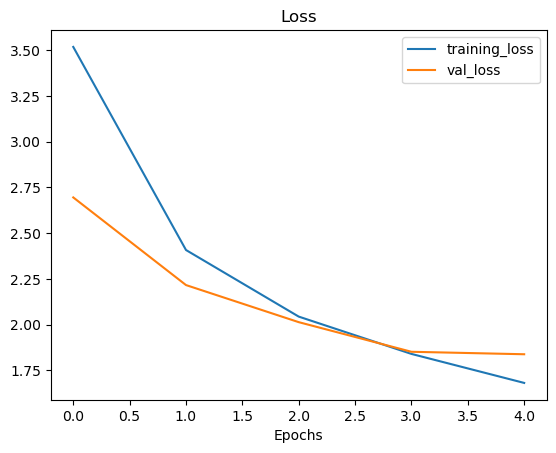

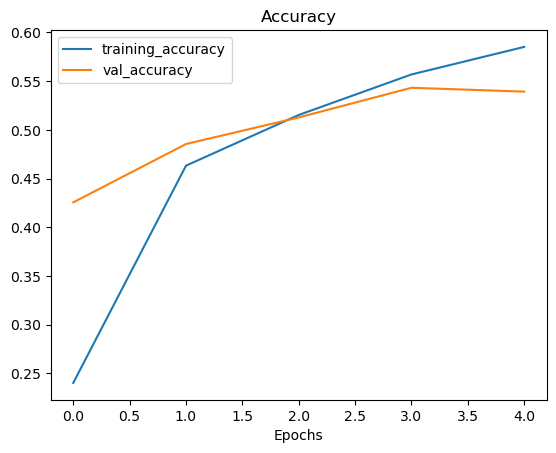

In [21]:
plot_loss_curves(history_0)

## Fine tuning

In [25]:
base_model.trainable = True

In [26]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [27]:
model_0.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # for fine tuning lr is less 10x
               metrics=["accuracy"])

In [28]:
finetune_history_0 = model_0.fit(train_data_gen,
                                epochs=10,
                                steps_per_epoch=len(train_data_gen),
                                validation_data=test_data_gen,
                                validation_steps=int(0.15 * len(test_data_gen)),
                                initial_epoch=history_0.epoch[-1],
                                callbacks=[create_tensorboard_callback("transfer_learning", "finetune_model_0")])

Saving TensorBoard log files to: transfer_learning/finetune_model_0/20230611-090843
Epoch 5/10
237/237 [==============================] - 54s 181ms/step - loss: 1.4193 - accuracy: 0.6269 - val_loss: 1.7972 - val_accuracy: 0.5297
Epoch 6/10
237/237 [==============================] - 37s 154ms/step - loss: 1.3403 - accuracy: 0.6484 - val_loss: 1.7716 - val_accuracy: 0.5400
Epoch 7/10
237/237 [==============================] - 34s 143ms/step - loss: 1.2562 - accuracy: 0.6686 - val_loss: 1.7939 - val_accuracy: 0.5368
Epoch 8/10
237/237 [==============================] - 36s 149ms/step - loss: 1.2233 - accuracy: 0.6780 - val_loss: 1.7203 - val_accuracy: 0.5453
Epoch 9/10
237/237 [==============================] - 35s 146ms/step - loss: 1.1378 - accuracy: 0.6999 - val_loss: 1.8154 - val_accuracy: 0.5336
Epoch 10/10
237/237 [==============================] - 34s 141ms/step - loss: 1.1168 - accuracy: 0.7023 - val_loss: 1.7663 - val_accuracy: 0.5387


In [29]:
model_0.evaluate(test_data_gen)

790/790 [==============================] - 49s 62ms/step - loss: 1.4879 - accuracy: 0.6039


[1.4879108667373657, 0.6038811802864075]

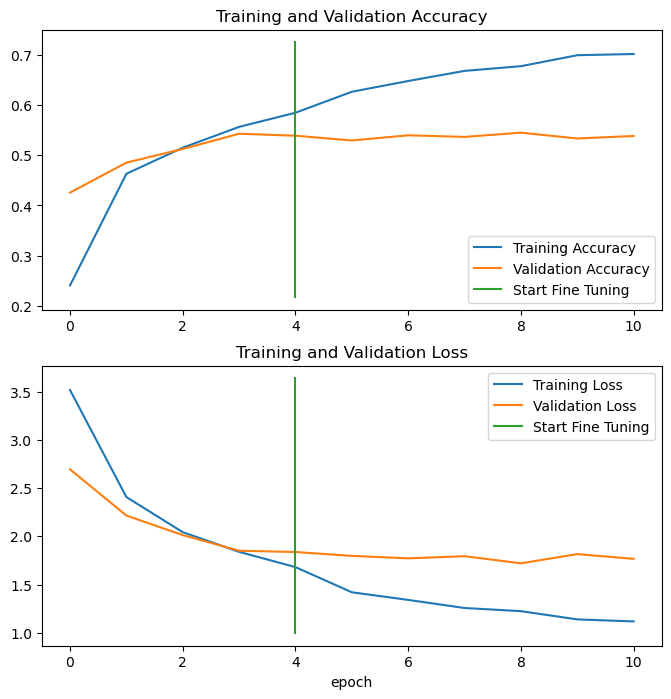

In [30]:
compare_historys(history_0, finetune_history_0, initial_epochs=5)

## Saving Model

In [32]:
 model_0.save("10_percent_model_0")

In [33]:
import shutil
shutil.make_archive("10_percent_model_0", 'zip', "10_percent_model_0")

'/kaggle/working/10_percent_model_0.zip'